<a href="https://colab.research.google.com/github/truclyst/google-colab-template/blob/AlphaFold2/Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [AdvancedBioinformatics1] Google colab notebook template

This is a template for Google colab notebook which will be used in your presentation
in Advanced Bioinformatics 1 lecture.
Your notebook should provide some examples of the method you present and contain 
these sections;
1. Install
2. Usage Test
3. Example
4. Visualization

## 00. Setup
Your notebook may contain some scripts which should be run before execution.
These are examples.

## 00-1. Mount Google Drive
You may mount data from your google drive with the cell below. 
Authenticate by tapping the address that appears on the screen and enter the verification code below it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 00-2. Open terminal
For running commands, you can open a shell with the code below.
If you click the address which starts with https://teleconsole.com, a new window with
a terminal will be opened. This terminal shares the program installed with the notebook.

In [ ]:
# You can run shell commands with "!" at the start of a line or "%%bash" at the start of a cell in the notebook.
!pip install kora
from kora import console
console.start()  # and click link

     |████████████████████████████████| 57 kB 2.5 MB/s 
     |████████████████████████████████| 56 kB 3.7 MB/s 



## 01. Installation
This section should be accompanied by a code with instructions on how to install it.

In [ ]:
#@title Install dependencies
%%bash -s $use_amber $use_msa $use_templates

USE_AMBER=$1
USE_MSA=$2
USE_TEMPLATES=$3

if [ ! -f AF2_READY ]; then
  # install dependencies
  pip -q install biopython dm-haiku ml-collections py3Dmol
  wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

  # download model
  if [ ! -d "alphafold/" ]; then
    git clone https://github.com/deepmind/alphafold.git --quiet
    (cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b --quiet)
    mv alphafold alphafold_
    mv alphafold_/alphafold .
    # remove "END" from PDBs, otherwise biopython complains
    sed -i "s/pdb_lines.append('END')//" /content/alphafold/common/protein.py
    sed -i "s/pdb_lines.append('ENDMDL')//" /content/alphafold/common/protein.py
  fi

  # download model params (~1 min)
  if [ ! -d "params/" ]; then
    mkdir params
    curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar \
    | tar x -C params
  fi
  touch AF2_READY
fi
# download libraries for interfacing with MMseqs2 API
if [ ${USE_MSA} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f MMSEQ2_READY ]; then
    apt-get -qq -y update 2>&1 1>/dev/null
    apt-get -qq -y install jq curl zlib1g gawk 2>&1 1>/dev/null
    touch MMSEQ2_READY
  fi
fi
# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  conda install -y -q -c conda-forge -c bioconda kalign3=3.2.2 hhsuite=3.3.0 python=3.7 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  conda install -y -q -c conda-forge openmm=7.5.1 python=3.7 pdbfixer 2>&1 1>/dev/null
  (cd /usr/local/lib/python3.7/site-packages; patch -s -p0 < /content/alphafold_/docker/openmm.patch)
  wget -qnc https://git.scicore.unibas.ch/schwede/openstructure/-/raw/7102c63615b64735c4941278d92b554ec94415f8/modules/mol/alg/src/stereo_chemical_props.txt
  mv stereo_chemical_props.txt alphafold/common/
  touch AMBER_READY
fi

## 03. Example

In [ ]:
#@title Input protein sequence
from google.colab import files
import os
import os.path
import re
import hashlib

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGP DEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAK SVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHE RCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNS SCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELP PGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPG GSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD' #@param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
query_sequence = re.sub(r'[^a-zA-Z]','', query_sequence).upper()

jobname = 'test' #@param {type:"string"}
# remove whitespaces
jobname = "".join(jobname.split())
jobname = re.sub(r'\W+', '', jobname)
jobname = add_hash(jobname, query_sequence)


with open(f"{jobname}.fasta", "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

# number of models to use
#@markdown ---
#@markdown ### Advanced settings
msa_mode = "MMseqs2 (UniRef+Environmental)" #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
num_models = 5 #@param [1,2,3,4,5] {type:"raw"}
use_msa = True if msa_mode.startswith("MMseqs2") else False
use_env = True if msa_mode == "MMseqs2 (UniRef+Environmental)" else False
use_custom_msa = True if msa_mode == "custom" else False
use_amber = False #@param {type:"boolean"}
use_templates = False #@param {type:"boolean"}
#@markdown ---
#@markdown ### Experimental options
homooligomer = 1 #@param [1,2,3,4,5,6,7,8] {type:"raw"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown ---

if homooligomer > 1:
  if use_amber:
    print("amber disabled: amber is not currently supported for homooligomers")
    use_amber = False
  if use_templates:
    print("templates disabled: templates are not currently supported for homooligomers")
    use_templates = False

with open(f"{jobname}.log", "w") as text_file:
    text_file.write("num_models=%s\n" % num_models)
    text_file.write("use_amber=%s\n" % use_amber)
    text_file.write("use_msa=%s\n" % use_msa)
    text_file.write("msa_mode=%s\n" % msa_mode)
    text_file.write("use_templates=%s\n" % use_templates)
    text_file.write("homooligomer=%s\n" % homooligomer)

# decide which a3m to use
if use_msa:
  a3m_file = f"{jobname}.a3m"
elif use_custom_msa:
  a3m_file = f"{jobname}.custom.a3m"
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1 
      if line.startswith("#"):
        continue
      if line.rstrip() == False:
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip() 
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    print(f"moving {custom_msa} to {a3m_file}")
else:
  a3m_file = f"{jobname}.single_sequence.a3m"
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

if save_to_google_drive == True:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

In [ ]:
#@title Import libraries
# setup the model
if "model" not in dir():

  # hiding warning messages
  import warnings
  from absl import logging
  import os
  import tensorflow as tf
  warnings.filterwarnings('ignore')
  logging.set_verbosity("error")
  os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
  tf.get_logger().setLevel('ERROR')

  import sys
  import numpy as np
  import pickle
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.data import templates
  from alphafold.model import data
  from alphafold.model import config
  from alphafold.model import model
  from alphafold.data.tools import hhsearch
  import colabfold as cf

  # plotting libraries
  import py3Dmol
  import matplotlib.pyplot as plt
  import ipywidgets
  from ipywidgets import interact, fixed, GridspecLayout, Output


if use_amber and "relax" not in dir():
  sys.path.insert(0, '/usr/local/lib/python3.7/site-packages/')
  from alphafold.relax import relax

def mk_mock_template(query_sequence):
  # since alphafold's model requires a template input
  # we create a blank example w/ zero input, confidence -1
  ln = len(query_sequence)
  output_templates_sequence = "-"*ln
  output_confidence_scores = np.full(ln,-1)
  templates_all_atom_positions = np.zeros((ln, templates.residue_constants.atom_type_num, 3))
  templates_all_atom_masks = np.zeros((ln, templates.residue_constants.atom_type_num))
  templates_aatype = templates.residue_constants.sequence_to_onehot(output_templates_sequence,
                                                                    templates.residue_constants.HHBLITS_AA_TO_ID)
  template_features = {'template_all_atom_positions': templates_all_atom_positions[None],
                       'template_all_atom_masks': templates_all_atom_masks[None],
                       'template_sequence': [f'none'.encode()],
                       'template_aatype': np.array(templates_aatype)[None],
                       'template_confidence_scores': output_confidence_scores[None],
                       'template_domain_names': [f'none'.encode()],
                       'template_release_date': [f'none'.encode()]}
  return template_features

def mk_template(a3m_lines, template_paths):
  template_featurizer = templates.TemplateHitFeaturizer(
      mmcif_dir=template_paths,
      max_template_date="2100-01-01",
      max_hits=20,
      kalign_binary_path="kalign",
      release_dates_path=None,
      obsolete_pdbs_path=None)

  hhsearch_pdb70_runner = hhsearch.HHSearch(binary_path="hhsearch", databases=[f"{template_paths}/pdb70"])

  hhsearch_result = hhsearch_pdb70_runner.query(a3m_lines)
  hhsearch_hits = pipeline.parsers.parse_hhr(hhsearch_result)
  templates_result = template_featurizer.get_templates(query_sequence=query_sequence,
                                                       query_pdb_code=None,
                                                       query_release_date=None,
                                                       hits=hhsearch_hits)
  return templates_result.features

def set_bfactor(pdb_filename, bfac, idx_res, chains):
  I = open(pdb_filename,"r").readlines()
  O = open(pdb_filename,"w")
  for line in I:
    if line[0:6] == "ATOM  ":
      seq_id = int(line[22:26].strip()) - 1
      seq_id = np.where(idx_res == seq_id)[0][0]
      O.write(f"{line[:21]}{chains[seq_id]}{line[22:60]}{bfac[seq_id]:6.2f}{line[66:]}")
  O.close()

def predict_structure(prefix, feature_dict, Ls, model_params, use_model, do_relax=False, random_seed=0):  
  """Predicts structure using AlphaFold for the given sequence."""

  # Minkyung's code
  # add big enough number to residue index to indicate chain breaks
  idx_res = feature_dict['residue_index']
  L_prev = 0
  # Ls: number of residues in each chain
  for L_i in Ls[:-1]:
      idx_res[L_prev+L_i:] += 200
      L_prev += L_i  
  chains = list("".join([ascii_uppercase[n]*L for n,L in enumerate(Ls)]))
  feature_dict['residue_index'] = idx_res

  # Run the models.
  plddts,paes = [],[]
  unrelaxed_pdb_lines = []
  relaxed_pdb_lines = []

  for model_name, params in model_params.items():
    if model_name in use_model:
      print(f"running {model_name}")
      # swap params to avoid recompiling
      # note: models 1,2 have diff number of params compared to models 3,4,5
      if any(str(m) in model_name for m in [1,2]): model_runner = model_runner_1
      if any(str(m) in model_name for m in [3,4,5]): model_runner = model_runner_3
      model_runner.params = params
      
      processed_feature_dict = model_runner.process_features(feature_dict, random_seed=random_seed)
      prediction_result = model_runner.predict(processed_feature_dict)
      unrelaxed_protein = protein.from_prediction(processed_feature_dict,prediction_result)
      unrelaxed_pdb_lines.append(protein.to_pdb(unrelaxed_protein))
      plddts.append(prediction_result['plddt'])
      paes.append(prediction_result['predicted_aligned_error'])

      if do_relax:
        # Relax the prediction.
        amber_relaxer = relax.AmberRelaxation(max_iterations=0,tolerance=2.39,
                                              stiffness=10.0,exclude_residues=[],
                                              max_outer_iterations=20)      
        relaxed_pdb_str, _, _ = amber_relaxer.process(prot=unrelaxed_protein)
        relaxed_pdb_lines.append(relaxed_pdb_str)

  # rerank models based on predicted lddt
  lddt_rank = np.mean(plddts,-1).argsort()[::-1]
  out = {}
  print("reranking models based on avg. predicted lDDT")
  for n,r in enumerate(lddt_rank):
    print(f"model_{n+1} {np.mean(plddts[r])}")

    unrelaxed_pdb_path = f'{prefix}_unrelaxed_model_{n+1}.pdb'    
    with open(unrelaxed_pdb_path, 'w') as f: f.write(unrelaxed_pdb_lines[r])
    set_bfactor(unrelaxed_pdb_path, plddts[r], idx_res, chains)

    if do_relax:
      relaxed_pdb_path = f'{prefix}_relaxed_model_{n+1}.pdb'
      with open(relaxed_pdb_path, 'w') as f: f.write(relaxed_pdb_lines[r])
      set_bfactor(relaxed_pdb_path, plddts[r], idx_res, chains)

    out[f"model_{n+1}"] = {"plddt":plddts[r], "pae":paes[r]}
  return out

In [ ]:
#@title Call MMseqs2 to get MSA/templates
if use_templates:
  a3m_lines, template_paths = cf.run_mmseqs2(query_sequence, jobname, use_env, use_templates=True)
  if template_paths is None:
    template_features = mk_mock_template(query_sequence * homooligomer)
  else:
    template_features = mk_template(a3m_lines, template_paths)
elif use_msa:
  a3m_lines = cf.run_mmseqs2(query_sequence, jobname, use_env)
  template_features = mk_mock_template(query_sequence * homooligomer)
else:
  template_features = mk_mock_template(query_sequence * homooligomer)

if use_msa:
  with open(a3m_file, "w") as text_file:
    text_file.write(a3m_lines)
else:
  a3m_lines = "".join(open(a3m_file,"r").read())

# parse MSA
msa, deletion_matrix = pipeline.parsers.parse_a3m(a3m_lines)

  0%|          | 0/150 [elapsed: 00:00 remaining: ?]

In [ ]:
#@title Gather input features, predict structure
from string import ascii_uppercase

# collect model weights
use_model = {}
if "model_params" not in dir(): model_params = {}
for model_name in ["model_1","model_2","model_3","model_4","model_5"][:num_models]:
  use_model[model_name] = True
  if model_name not in model_params:
    model_params[model_name] = data.get_model_haiku_params(model_name=model_name+"_ptm", data_dir=".")
    if model_name == "model_1":
      model_config = config.model_config(model_name+"_ptm")
      model_config.data.eval.num_ensemble = 1
      model_runner_1 = model.RunModel(model_config, model_params[model_name])
    if model_name == "model_3":
      model_config = config.model_config(model_name+"_ptm")
      model_config.data.eval.num_ensemble = 1
      model_runner_3 = model.RunModel(model_config, model_params[model_name])

if homooligomer == 1:
  msas = [msa]
  deletion_matrices = [deletion_matrix]
else:
  # make multiple copies of msa for each copy
  # AAA------
  # ---AAA---
  # ------AAA
  #
  # note: if you concat the sequences (as below), it does NOT work
  # AAAAAAAAA
  msas = []
  deletion_matrices = []
  Ln = len(query_sequence)
  for o in range(homooligomer):
    L = Ln * o
    R = Ln * (homooligomer-(o+1))
    msas.append(["-"*L+seq+"-"*R for seq in msa])
    deletion_matrices.append([[0]*L+mtx+[0]*R for mtx in deletion_matrix])

# gather features
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence*homooligomer,
                                      description="none",
                                      num_res=len(query_sequence)*homooligomer),
    **pipeline.make_msa_features(msas=msas,deletion_matrices=deletion_matrices),
    **template_features
}
outs = predict_structure(jobname, feature_dict,
                         Ls=[len(query_sequence)]*homooligomer,
                         model_params=model_params, use_model=use_model,
                         do_relax=use_amber)

running model_1
running model_2
running model_3
running model_4
running model_5
reranking models based on avg. predicted lDDT
model_1 71.85726960859073
model_2 71.64685630209979
model_3 70.65018709615256
model_4 70.30977620494158
model_5 69.81328034473493


## 04. Visualization

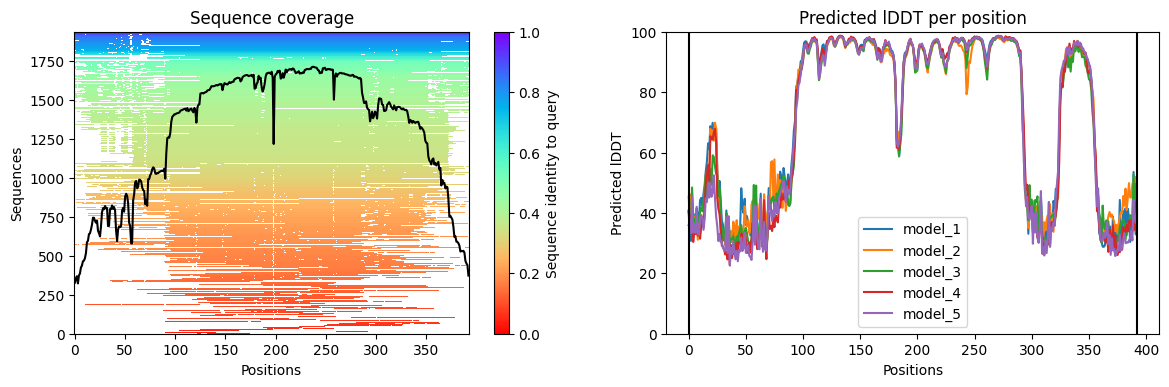

Predicted Alignment Error


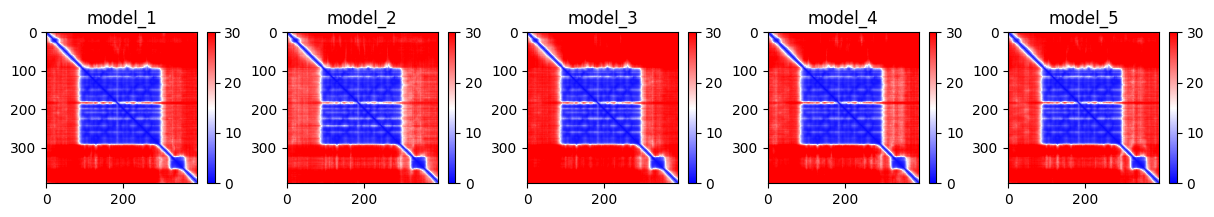

In [ ]:
#@title Make plots

# gather MSA info
deduped_full_msa = list(dict.fromkeys(msa))
msa_arr = np.array([list(seq) for seq in deduped_full_msa])
seqid = (np.array(list(query_sequence)) == msa_arr).mean(-1)
seqid_sort = seqid.argsort() #[::-1]
non_gaps = (msa_arr != "-").astype(float)
non_gaps[non_gaps == 0] = np.nan

##################################################################
plt.figure(figsize=(14,4),dpi=100)
##################################################################
plt.subplot(1,2,1); plt.title("Sequence coverage")
plt.imshow(non_gaps[seqid_sort]*seqid[seqid_sort,None],
           interpolation='nearest', aspect='auto',
           cmap="rainbow_r", vmin=0, vmax=1, origin='lower')
plt.plot((msa_arr != "-").sum(0), color='black')
plt.xlim(-0.5,msa_arr.shape[1]-0.5)
plt.ylim(-0.5,msa_arr.shape[0]-0.5)
plt.colorbar(label="Sequence identity to query",)
plt.xlabel("Positions")
plt.ylabel("Sequences")

##################################################################
plt.subplot(1,2,2); plt.title("Predicted lDDT per position")
for model_name,value in outs.items():
  plt.plot(value["plddt"],label=model_name)
if homooligomer > 0:
  for n in range(homooligomer+1):
    x = n*(len(query_sequence)-1)
    plt.plot([x,x],[0,100],color="black")
plt.legend()
plt.ylim(0,100)
plt.ylabel("Predicted lDDT")
plt.xlabel("Positions")
plt.savefig(jobname+"_coverage_lDDT.png")
##################################################################
plt.show()

print("Predicted Alignment Error")
##################################################################
plt.figure(figsize=(3*num_models,2), dpi=100)
for n,(model_name,value) in enumerate(outs.items()):
  plt.subplot(1,num_models,n+1)
  plt.title(model_name)
  plt.imshow(value["pae"],label=model_name,cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
plt.savefig(jobname+"_PAE.png")
plt.show()
##################################################################

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

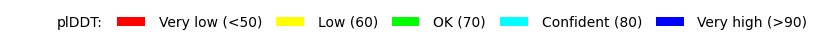

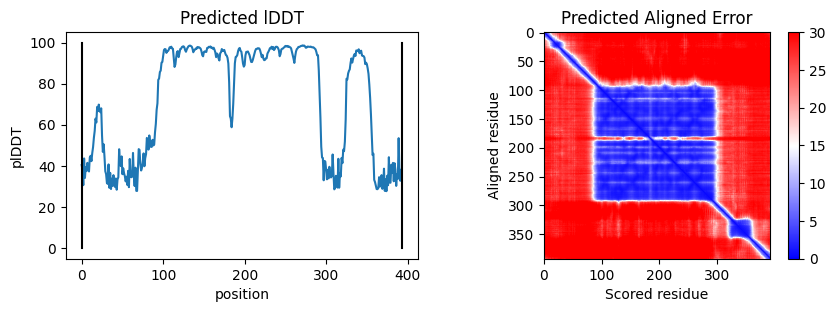

In [ ]:
#@title Display 3D structure {run: "auto"}
model_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

def plot_plddt_legend():
  thresh = ['plDDT:','Very low (<50)','Low (60)','OK (70)','Confident (80)','Very high (>90)']
  plt.figure(figsize=(1,0.1),dpi=100)
  ########################################
  for c in ["#FFFFFF","#FF0000","#FFFF00","#00FF00","#00FFFF","#0000FF"]:
    plt.bar(0, 0, color=c)
  plt.legend(thresh, frameon=False,
             loc='center', ncol=6,
             handletextpad=1,
             columnspacing=1,
             markerscale=0.5,)
  plt.axis(False)
  return plt

def plot_confidence(model_num=1):
  model_name = f"model_{model_num}"
  plt.figure(figsize=(10,3),dpi=100)
  """Plots the legend for plDDT."""
  #########################################
  plt.subplot(1,2,1); plt.title('Predicted lDDT')
  plt.plot(outs[model_name]["plddt"])
  for n in range(homooligomer+1):
    x = n*(len(query_sequence))
    plt.plot([x,x],[0,100],color="black")
  plt.ylabel('plDDT')
  plt.xlabel('position')
  #########################################
  plt.subplot(1,2,2);plt.title('Predicted Aligned Error')
  plt.imshow(outs[model_name]["pae"], cmap="bwr",vmin=0,vmax=30)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')
  #########################################
  return plt

def show_pdb(model_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"model_{model_num}"
  if use_amber:
    pdb_filename = f"{jobname}_relaxed_{model_name}.pdb"
  else:
    pdb_filename = f"{jobname}_unrelaxed_{model_name}.pdb"

  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_filename,'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(homooligomer),list("ABCDEFGH"),
                     ["lime","cyan","magenta","yellow","salmon","white","blue","orange"]):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(model_num,show_sidechains, show_mainchains, color).show()
if color == "lDDT": plot_plddt_legend().show()  
plot_confidence(model_num).show()

In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

citations = {
"Mirdita2021":  """@article{Mirdita2021,
author = {Mirdita, Milot and Ovchinnikov, Sergey and Steinegger, Martin},
doi = {10.1101/2021.08.15.456425},
journal = {bioRxiv},
title = {{ColabFold - Making Protein folding accessible to all}},
year = {2021},
comment = {ColabFold including MMseqs2 MSA server}
}""",
  "Mitchell2019": """@article{Mitchell2019,
author = {Mitchell, Alex L and Almeida, Alexandre and Beracochea, Martin and Boland, Miguel and Burgin, Josephine and Cochrane, Guy and Crusoe, Michael R and Kale, Varsha and Potter, Simon C and Richardson, Lorna J and Sakharova, Ekaterina and Scheremetjew, Maxim and Korobeynikov, Anton and Shlemov, Alex and Kunyavskaya, Olga and Lapidus, Alla and Finn, Robert D},
doi = {10.1093/nar/gkz1035},
journal = {Nucleic Acids Res.},
title = {{MGnify: the microbiome analysis resource in 2020}},
year = {2019},
comment = {MGnify database}
}""",
  "Eastman2017": """@article{Eastman2017,
author = {Eastman, Peter and Swails, Jason and Chodera, John D. and McGibbon, Robert T. and Zhao, Yutong and Beauchamp, Kyle A. and Wang, Lee-Ping and Simmonett, Andrew C. and Harrigan, Matthew P. and Stern, Chaya D. and Wiewiora, Rafal P. and Brooks, Bernard R. and Pande, Vijay S.},
doi = {10.1371/journal.pcbi.1005659},
journal = {PLOS Comput. Biol.},
number = {7},
title = {{OpenMM 7: Rapid development of high performance algorithms for molecular dynamics}},
volume = {13},
year = {2017},
comment = {Amber relaxation}
}""",
  "Jumper2021": """@article{Jumper2021,
author = {Jumper, John and Evans, Richard and Pritzel, Alexander and Green, Tim and Figurnov, Michael and Ronneberger, Olaf and Tunyasuvunakool, Kathryn and Bates, Russ and {\v{Z}}{\'{i}}dek, Augustin and Potapenko, Anna and Bridgland, Alex and Meyer, Clemens and Kohl, Simon A. A. and Ballard, Andrew J. and Cowie, Andrew and Romera-Paredes, Bernardino and Nikolov, Stanislav and Jain, Rishub and Adler, Jonas and Back, Trevor and Petersen, Stig and Reiman, David and Clancy, Ellen and Zielinski, Michal and Steinegger, Martin and Pacholska, Michalina and Berghammer, Tamas and Bodenstein, Sebastian and Silver, David and Vinyals, Oriol and Senior, Andrew W. and Kavukcuoglu, Koray and Kohli, Pushmeet and Hassabis, Demis},
doi = {10.1038/s41586-021-03819-2},
journal = {Nature},
pmid = {34265844},
title = {{Highly accurate protein structure prediction with AlphaFold.}},
year = {2021},
comment = {AlphaFold2 + BFD Database}
}""",
  "Mirdita2019": """@article{Mirdita2019,
author = {Mirdita, Milot and Steinegger, Martin and S{\"{o}}ding, Johannes},
doi = {10.1093/bioinformatics/bty1057},
journal = {Bioinformatics},
number = {16},
pages = {2856--2858},
pmid = {30615063},
title = {{MMseqs2 desktop and local web server app for fast, interactive sequence searches}},
volume = {35},
year = {2019},
comment = {MMseqs2 search server}
}""",
  "Steinegger2019": """@article{Steinegger2019,
author = {Steinegger, Martin and Meier, Markus and Mirdita, Milot and V{\"{o}}hringer, Harald and Haunsberger, Stephan J. and S{\"{o}}ding, Johannes},
doi = {10.1186/s12859-019-3019-7},
journal = {BMC Bioinform.},
number = {1},
pages = {473},
pmid = {31521110},
title = {{HH-suite3 for fast remote homology detection and deep protein annotation}},
volume = {20},
year = {2019},
comment = {PDB70 database}
}""",
  "Mirdita2017": """@article{Mirdita2017,
author = {Mirdita, Milot and von den Driesch, Lars and Galiez, Clovis and Martin, Maria J. and S{\"{o}}ding, Johannes and Steinegger, Martin},
doi = {10.1093/nar/gkw1081},
journal = {Nucleic Acids Res.},
number = {D1},
pages = {D170--D176},
pmid = {27899574},
title = {{Uniclust databases of clustered and deeply annotated protein sequences and alignments}},
volume = {45},
year = {2017},
comment = {Uniclust30/UniRef30 database},
}""",
  "Berman2003": """@misc{Berman2003,
author = {Berman, Helen and Henrick, Kim and Nakamura, Haruki},
booktitle = {Nat. Struct. Biol.},
doi = {10.1038/nsb1203-980},
number = {12},
pages = {980},
pmid = {14634627},
title = {{Announcing the worldwide Protein Data Bank}},
volume = {10},
year = {2003},
comment = {templates downloaded from wwPDB server}
}""",
}

to_cite = [ "Mirdita2021", "Jumper2021" ]
if use_msa:       to_cite += ["Mirdita2019"]
if use_msa:       to_cite += ["Mirdita2017"]
if use_env:       to_cite += ["Mitchell2019"]
if use_templates: to_cite += ["Steinegger2019"]
if use_templates: to_cite += ["Berman2003"]
if use_amber:     to_cite += ["Eastman2017"]

with open(f"{jobname}.bibtex", 'w') as writer:
  for i in to_cite:
    writer.write(citations[i])
    writer.write("\n")

print(f"Found {len(to_cite)} citation{'s' if len(to_cite) > 1 else ''} for tools or databases.")
if use_custom_msa:
  print("Don't forget to cite your custom MSA generation method.")

!zip -FSr $jobname".result.zip" $jobname".log" $a3m_file $jobname"_"*"relaxed_model_"*".pdb" $jobname"_coverage_lDDT.png" $jobname".bibtex" $jobname"_PAE.png"
files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive != None:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

Found 5 citations for tools or databases.
  adding: test_7c637.log (deflated 14%)
  adding: test_7c637.a3m (deflated 75%)
  adding: test_7c637_unrelaxed_model_1.pdb (deflated 78%)
  adding: test_7c637_unrelaxed_model_2.pdb (deflated 78%)
  adding: test_7c637_unrelaxed_model_3.pdb (deflated 78%)
  adding: test_7c637_unrelaxed_model_4.pdb (deflated 78%)
  adding: test_7c637_unrelaxed_model_5.pdb (deflated 78%)
  adding: test_7c637_coverage_lDDT.png (deflated 3%)
  adding: test_7c637.bibtex (deflated 53%)
  adding: test_7c637_PAE.png (deflated 1%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>